In [1]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import pingouin as pg
import scikit_posthocs as sp

from plotly import graph_objects as go
from plotly.subplots import make_subplots
from itertools import combinations
from scipy.stats import f_oneway, kruskal, ttest_ind, shapiro, mannwhitneyu, levene
from matplotlib_venn import venn2,venn2_circles
from matplotlib import pyplot as plt

## Directories and constants
FIGURES_DIR = './figures/Pain'
MODELS_DIR = './src/models'
DATA_DIR = '/home/filthyweeb/Documents/SeriousStuff/Work/MScThesis/csv/Pain_Plot_Features'
MEAN_FEATURES_FILE = './csv/Pain_hindlimb_mouse_features_2025-06-22_21-53-52.csv' # updated means and circular means
FORELIMB_MEANS_FILE = './csv/Pain_forelimb_mouse_features_2025-06-22_21-53-53.csv' # updated means and circular means
# MEAN_FEATURES_FILE = './csv/SCI_pre_acute_hindlimb_mouse_features_2025-06-06_15-11-59.csv'
# MEAN_FEATURES_FILE = './csv/sideview_hindlimb_mouse_features_new_H.csv'
HEALTHY_KEY = 'pre'
SICK_KEY = 'post'
CONTROL_KEY = 'C_'
SECONDARY_CONTROL_KEY = 'A_'
VIRUS_CONTROL_KEY = 'B_'
TREATMENT_CONTROL_KEY = 'E_'
SECONDARY_TREATMENT_KEY = 'D_'
SIDE_KEY = ('left','right')

## Treatments: E-D
## Controls: B-C

## C-B to check if virus is doing something or is it the lesion
## A should be similar to C

### Functions for statistical testing
def is_circular_feature(name):
    name = name.lower()
    return (('angle' in name or 'phase' in name) and 'excursion' not in name and 'std' not in name)

def circular_surrogate_test(values1, values2):
    """Approximate test for circular data by comparing cosine and sine projections. Input in radiants"""
    cos1, sin1 = np.cos(values1), np.sin(values1)
    cos2, sin2 = np.cos(values2), np.sin(values2)

    _, p_cos = ttest_ind(cos1, cos2, equal_var=False)
    _, p_sin = ttest_ind(sin1, sin2, equal_var=False)

    min_p = min(p_cos, p_sin)
    axis = 'cos' if p_cos < p_sin else 'sin'

    return min_p, axis

def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'n.s.'

def bonferroni_correct(p, n=3):
    return min(p * n, 1.0)

def compare_feature_sets(group1, group2, group1_name='group1', group2_name='group2'):
    results = []
    common_features = set(group1.columns).intersection(set(group2.columns))
    common_features = [f for f in common_features if f != 'Dataset' and f != 'Mouse']

    for feature in sorted(common_features):
        test = ''
        g1 = group1[feature].dropna()
        g2 = group2[feature].dropna()

        n1 = len(g1)
        n2 = len(g2)

        if n1 < 3 or n2 < 3:
            continue  # skip features with too few samples

        circular = is_circular_feature(feature)

        # Compute basic stats
        mean1 = np.mean(g1)
        std1 = np.std(g1, ddof=1)
        mean2 = np.mean(g2)
        std2 = np.std(g2, ddof=1)

        # Statistical testing
        if circular:
            test = 'Circular'
            try:
                # pycircstat expects radians
                if '°' in feature: 
                    g1 = np.deg2rad(g1)
                    g2 = np.deg2rad(g2)
                pval, _ = circular_surrogate_test(g1, g2)
            except Exception:
                pval = np.nan
        elif 'std' in feature.lower():
            test = 'Levene'
            stat, pval = levene(g1, g2)
        else:
            # Normality check
            norm1 = shapiro(g1).pvalue > 0.05
            norm2 = shapiro(g2).pvalue > 0.05

            if norm1 and norm2:
                test = 'T-test'
                _, pval = ttest_ind(g1, g2, equal_var=False)
            else:
                test = 'Mann-Whitney U'
                _, pval = mannwhitneyu(g1, g2, alternative='two-sided')

        sig = significance_stars(pval)

        results.append({
            'Feature': feature,
            f'Mean {group1_name}': mean1,
            f'SD {group1_name}': std1,
            f'Mean {group2_name}': mean2,
            f'SD {group2_name}': std2,
            f'Number of samples in {group1_name}': n1,
            f'Number of samples in {group2_name}': n2,
            f'p-value {group1_name} vs {group2_name}': pval,
            'Significance': sig,
            'Statistical Test': test
        })

    return pd.DataFrame(results)

def compare_multiple_groups(group_dict):
    """
    group_dict: dict with keys as group names (e.g., 'H', 'S', 'T')
                and values as DataFrames with same features
    """
    group_nbr = len(group_dict)
    results = []
    feature_set = set.intersection(*(set(df.columns) for df in group_dict.values()))
    feature_set = [f for f in feature_set if f != 'Dataset' and f != 'Mouse']
    group_names = list(group_dict.keys())

    for feature in sorted(feature_set):
        group_data = {g: df[feature].dropna() for g, df in group_dict.items()}
        sample_sizes = {g: len(vals) for g, vals in group_data.items()}

        if any(n < 3 for n in sample_sizes.values()):
            continue  # skip if any group has <3 samples

        circular = is_circular_feature(feature)
        summary_stats = {
            f"Mean {g}": np.mean(vals)
            for g, vals in group_data.items()
        }
        summary_stats.update({
            f"SD {g}": np.std(vals, ddof=1)
            for g, vals in group_data.items()
        })
        summary_stats.update({
            f"Number of samples in {g}": len(vals)
            for g, vals in group_data.items()
        })

        # Global test
        pval_global = np.nan
        posthoc_matrix = {}

        all_vals = []
        labels = []
        for g in group_names:
            v = group_data[g]
            v = np.deg2rad(v) if '°' in feature else v
            labels.extend([g]*len(v))
            all_vals.extend(v)
        all_df = pd.DataFrame({'value': all_vals, 'group': labels})

        if circular:
            ## Global p-value circular
            cos_groups = [np.cos(np.deg2rad(group_data[g])) for g in group_names]
            sin_groups = [np.sin(np.deg2rad(group_data[g])) for g in group_names]
            f_cos, p_cos = f_oneway(*cos_groups)
            f_sin, p_sin = f_oneway(*sin_groups)
            pval_global = min(p_cos, p_sin)
            test_used = "Circular"

            for g1, g2 in combinations(group_names, 2):
                p, _ = circular_surrogate_test(group_data[g1], group_data[g2])
                posthoc_matrix[(g1, g2)] = bonferroni_correct(p, group_nbr)
        elif 'std' in feature.lower():
            stat, pval_global = levene(*(group_data[g] for g in group_names))
            test_used = "Levene"
            for g1, g2 in combinations(group_names, 2):
                stat, p = levene(group_data[g1], group_data[g2])
                posthoc_matrix[(g1, g2)] = bonferroni_correct(p, group_nbr)
        else:
            # Check normality
            normal_flags = {
                g: shapiro(group_data[g]).pvalue > 0.05
                for g in group_names
            }

            if all(normal_flags.values()):
                pval_global = f_oneway(*group_data.values()).pvalue
                test_used = "ANOVA"

                posthoc = pg.pairwise_tests(
                    data=all_df,
                    dv='value',
                    between='group',
                    padjust='bonf',   # Bonferroni correction
                    alpha=0.05
                )

                # Pairwise t-tests
                for g1, g2 in combinations(group_names, 2):
                    match = posthoc[
                        ((posthoc['A'] == g1) & (posthoc['B'] == g2)) |
                        ((posthoc['A'] == g2) & (posthoc['B'] == g1))
                    ]
                    if not match.empty:
                        p = match.iloc[0]['p-corr']
                        posthoc_matrix[(g1, g2)] = p

            else:
                pval_global = kruskal(*group_data.values()).pvalue
                test_used = "Kruskal-Wallis"
                # scikit-posthocs needs long-format DataFrame
                posthoc = sp.posthoc_dunn(all_df, val_col='value', group_col='group', p_adjust='bonferroni')
                for g1, g2 in combinations(group_names, 2):
                    p = posthoc.loc[g1, g2]
                    posthoc_matrix[(g1, g2)] = p

        # Store pairwise comparisons
        row = {
            'Feature': feature,
            'Statistical Test': test_used,
            'Global p-value': pval_global,
            'Global significance': significance_stars(pval_global)
        }

        # Add group-wise stats
        for g in group_names:
            row[f'Mean {g}'] = summary_stats[f'Mean {g}']
            row[f'SD {g}'] = summary_stats[f'SD {g}']
            row[f'Number of samples in {g}'] = summary_stats[f'Number of samples in {g}']

        # Add pairwise p-values
        for g1, g2 in combinations(group_names, 2):
            p = posthoc_matrix.get((g1, g2), np.nan)
            row[f'p-value {g1} vs {g2}'] = p
            row[f'Significance {g1} vs {g2}'] = significance_stars(p)

        results.append(row)

    return pd.DataFrame(results)

In [2]:
# Example inputs: update as needed
experimental_groups = ['A', 'B', 'C', 'D', 'E']
sides = {'left': SIDE_KEY[0].lower(), 'right': SIDE_KEY[1].lower()}
health_statuses = {'healthy': HEALTHY_KEY.lower(), 'sick': SICK_KEY.lower()}
run_types = {
    'A': SECONDARY_CONTROL_KEY.lower(),
    'B': VIRUS_CONTROL_KEY.lower(),
    'C': CONTROL_KEY.lower(),
    'D': SECONDARY_TREATMENT_KEY.lower(),
    'E': TREATMENT_CONTROL_KEY.lower()
}

# Load data
hindlimb_features_df = pd.read_csv(MEAN_FEATURES_FILE)
forelimb_features_df = pd.read_csv(FORELIMB_MEANS_FILE) 

# filter number of runs and number of steps
hindlimb_features_df = hindlimb_features_df[hindlimb_features_df.columns[~hindlimb_features_df.columns.str.contains('(#)|steps std')]]
forelimb_features_df = forelimb_features_df[forelimb_features_df.columns[~forelimb_features_df.columns.str.contains('(#)|steps std')]]

# Container for all feature subsets
feature_subsets = {
    'hindlimb': {},
    'forelimb': {}
}

# General function for filtering
def filter_features(df, health_key, run_key, side_key):
    return df[
        df['Dataset'].str.lower().str.contains(health_key) &
        df['Dataset'].str.lower().str.contains(run_key) &
        df['Mouse'].str.lower().str.contains(side_key)
    ]

# Generate subsets
for run_code in experimental_groups:
    run_key = run_types.get(run_code)
    if not run_key:
        continue  # skip undefined keys

    for health_label, health_key in health_statuses.items():
        for side_label, side_key in sides.items():
            name = f"{health_label}_{side_label}_{run_code}_run"

            feature_subsets['hindlimb'][name] = filter_features(hindlimb_features_df, health_key, run_key, side_key)
            feature_subsets['forelimb'][name] = filter_features(forelimb_features_df, health_key, run_key, side_key)

# Example usage
print(f"Number of hindlimb features: {hindlimb_features_df.shape[1]-3}")
print(f"Number of forelimb features: {forelimb_features_df.shape[1]-3}")

# Access a subset:
# feature_subsets['hindlimb']['healthy_left_c_run']
# print(hindlimb_features_df['Dataset'].unique(), hindlimb_features_df['Mouse'].unique())

Number of hindlimb features: 2679
Number of forelimb features: 2679


/tmp/ipykernel_11566/279459541.py:18: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  hindlimb_features_df = hindlimb_features_df[hindlimb_features_df.columns[~hindlimb_features_df.columns.str.contains('(#)|steps std')]]
/tmp/ipykernel_11566/279459541.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  forelimb_features_df = forelimb_features_df[forelimb_features_df.columns[~forelimb_features_df.columns.str.contains('(#)|steps std')]]


In [3]:
df_b_healthy = feature_subsets['hindlimb'].get('healthy_left_B_run')
df_a_healthy = feature_subsets['hindlimb'].get('healthy_left_A_run')
df_c_healthy = feature_subsets['hindlimb'].get('healthy_left_C_run')
df_d_healthy = feature_subsets['hindlimb'].get('healthy_left_D_run')
df_e_healthy = feature_subsets['hindlimb'].get('healthy_left_E_run')
df_b_sick = feature_subsets['hindlimb'].get('sick_left_B_run')
df_c_sick = feature_subsets['hindlimb'].get('sick_left_C_run')
df_e_sick = feature_subsets['hindlimb'].get('sick_left_E_run')

# 1. Compare B left healthy vs C left sick
if df_b_healthy is not None and not df_b_healthy.empty and df_c_sick is not None and not df_c_sick.empty:
    label1 = 'Healthy Left B'
    label2 = 'Sick Left C'
    b_c_result = compare_feature_sets(df_b_healthy, df_c_sick, group1_name=label1, group2_name=label2)

# 2. Compare C left healthy vs E left sick
if df_c_healthy is not None and not df_c_healthy.empty and df_e_sick is not None and not df_e_sick.empty:
    label1 = 'Healthy Left C'
    label2 = 'Sick Left E'
    c_e_result = compare_feature_sets(df_c_healthy, df_e_sick, group1_name=label1, group2_name=label2)

In [4]:
# 3. Compare B, C, E with a one-way ANOVA
if df_b_healthy is not None and not df_b_healthy.empty and df_c_sick is not None and not df_c_sick.empty and df_e_sick is not None and not df_e_sick.empty:
    label1 = 'Healthy Left B'
    label2 = 'Sick Left C'
    label3 = 'Sick Left E'
    b_c_e_anova_result = compare_multiple_groups({
        label1: df_b_healthy,
        label2: df_c_sick,
        label3: df_e_sick
    })

In [5]:
# 4. Compare All healthy groups
all_healthy_anova_result = compare_multiple_groups({
    'Healthy Left A': df_a_healthy,
    'Healthy Left B': df_b_healthy,
    'Healthy Left C': df_c_healthy,
    'Healthy Left D': df_d_healthy,
    'Healthy Left E': df_e_healthy
})

In [6]:
# 5. Compare All Healthy vs B,C as sick, and E as treatment
df1 = pd.concat([df_a_healthy, df_b_healthy, df_c_healthy, df_d_healthy, df_e_healthy])
df2 = pd.concat([df_b_sick, df_c_sick])
df3 = df_e_sick
all_healthy_bc_sick_e_treat_anova_result = compare_multiple_groups({
    'All Healthy': df1,
    'B Sick & C Sick': df2,
    'E Treatment': df3
})

In [7]:
def calculate_feature_changes(healthy:pd.DataFrame, sick:pd.DataFrame, treatment:pd.DataFrame, features:list):
    """
        Calculate changes in feature means and effect sizes between healthy, sick, and treatment groups. The distance is measured as the absolute difference in means compared to the healthy group and the effect is normalized against the pooled std. 
    """
    rows = []
    for f in features:
        h = healthy[f].dropna()
        s = sick[f].dropna()
        t = treatment[f].dropna()

        d_sick = abs(s.mean() - h.mean())
        d_treat = abs(t.mean() - h.mean())

        # Pooled std for Healthy vs Sick
        pooled_std = np.sqrt(((len(h)-1)*h.var() + (len(s)-1)*s.var()) / (len(h) + len(s) - 2))

        if pooled_std == 0:
            change_effect_size = np.nan
        else:
            change_effect_size = (d_sick - d_treat) / pooled_std

        rows.append((f, d_sick - d_treat, change_effect_size))

    res_df = pd.DataFrame(rows, columns=["feature", "change value", "change_effect_size"])
    res_df["direction"] = res_df["change_effect_size"].apply(lambda x: "towards_healthy" if x > 0 else "away_from_healthy" if x < 0 else "no_change")

    return res_df

### Calculate improving and worsening features
healthy_features = hindlimb_features_df[hindlimb_features_df['Dataset'].str.contains('B_pre') & hindlimb_features_df['Mouse'].str.contains('left')]
sick_features = hindlimb_features_df[hindlimb_features_df['Dataset'].str.contains('C_post') & hindlimb_features_df['Mouse'].str.contains('left')]
treatment_features = hindlimb_features_df[hindlimb_features_df['Dataset'].str.contains('E_post') & hindlimb_features_df['Mouse'].str.contains('left')]
value_features = hindlimb_features_df[hindlimb_features_df.columns[~hindlimb_features_df.columns.str.contains('Dataset|Mouse')]].columns

feature_change_df = calculate_feature_changes(healthy_features, sick_features, treatment_features, value_features)

In [8]:
treatment_effect_df = b_c_e_anova_result.merge(
    feature_change_df,
    left_on='Feature',
    right_on='feature',
    how='inner'
)

treatment_effect_df_expanded = all_healthy_bc_sick_e_treat_anova_result.merge(
    feature_change_df,
    left_on='Feature',
    right_on='feature',
    how='inner'
)

treatment_on_lesion_df = b_c_result.merge(
    feature_change_df,
    left_on='Feature',
    right_on='feature',
    how='inner'
)

treatment_on_healthy_df = c_e_result.merge(
    feature_change_df,
    left_on='Feature',
    right_on='feature',
    how='inner'
)

print(b_c_e_anova_result.shape, treatment_effect_df.shape, feature_change_df.shape, treatment_on_lesion_df.shape, b_c_result.shape, treatment_on_healthy_df.shape, c_e_result.shape)

(2680, 19) (2680, 23) (2680, 4) (2680, 14) (2680, 10) (2680, 14) (2680, 10)


In [9]:
## Save to csv the files
treatment_effect_df.to_csv('./treatment_effect_features.csv', index=False)
treatment_on_lesion_df.to_csv('./lesion_features.csv', index=False)
treatment_on_healthy_df.to_csv('./non_pathological_features.csv', index=False)

In [10]:
def plot_features_list_across_groups(feature_list, feature_subsets, limb='hindlimb', 
                                     max_cols=4, groups=['A_', 'B_', 'C_', 'D_', 'E_'], 
                                     states=['healthy', 'sick'], sides=['left', 'right']):
    """
    Plot a given list of exact feature names across all groups for a given limb.
    """
    data_subsets = feature_subsets[limb]
    matched_features = [f for f in feature_list if any(f in df.columns for df in data_subsets.values())]

    if not matched_features:
        print("No matching features found in the data.")
        return
    
    if 'ALL_' in groups:
        # Merge the relevant sick groups (excluding D and E)
        all_sick = pd.concat([
            feature_subsets[limb]['sick_left_B_run'],
            feature_subsets[limb]['sick_left_C_run']
        ], ignore_index=True)
        all_healthy = pd.concat([
            feature_subsets[limb]['healthy_left_B_run'],
            feature_subsets[limb]['healthy_left_C_run']
        ], ignore_index=True)
        feature_subsets[limb]['sick_left_ALL_run'] = all_sick
        feature_subsets[limb]['healthy_left_ALL_run'] = all_healthy

    num_features = len(matched_features)
    rows = (num_features + max_cols - 1) // max_cols
    cols = min(num_features, max_cols)

    palette = px.colors.qualitative.Plotly
    subplot_titles = [
        f.replace('Mean', '').replace('- rhindlimb - ', '').strip()
        for f in matched_features
    ]

    fig = make_subplots(rows=rows, cols=cols, subplot_titles=subplot_titles)

    for idx, feature in enumerate(matched_features):
        row = idx // max_cols + 1
        col = idx % max_cols + 1

        group_means, group_stds, group_names, group_points = [], [], [], []

        for name, df in data_subsets.items():
            if feature not in df.columns:
                continue
            if not any(side in name.lower() for side in sides):
                continue
            if not (any(g in name for g in groups) and any(s in name for s in states)):
                continue

            values = df[feature].dropna()
            if len(values) == 0:
                continue

            group_means.append(values.mean())
            group_stds.append(values.std())
            group_names.append(name)
            group_points.append(values)

        if not group_names:
            continue

        bar_colors = [palette[i % len(palette)] for i in range(len(group_names))]

        # Bar with error bars
        fig.add_trace(
            go.Bar(
                x=group_names,
                y=group_means,
                error_y=dict(type='data', array=group_stds, visible=True),
                name=feature,
                marker=dict(
                    color=bar_colors,
                    line=dict(color='black', width=1)
                )
            ),
            row=row, col=col
        )

        # Scatter points
        for i, (group, values) in enumerate(zip(group_names, group_points)):
            fig.add_trace(
                go.Scatter(
                    x=[group] * len(values),
                    y=values,
                    mode='markers',
                    marker=dict(size=6, opacity=0.5, color='black'),
                    showlegend=False
                ),
                row=row, col=col
            )

    fig.update_layout(
        title="Selected Features Across Groups",
        showlegend=False,
        height=500 * rows,
        width=400 * cols,
        plot_bgcolor='rgba(0,0,0,0)'
    )
    return fig

In [11]:
c_e_healthy_sig = set(all_healthy_anova_result[all_healthy_anova_result['Significance Healthy Left C vs Healthy Left E'] != 'n.s.']['Feature'])
print(len(c_e_healthy_sig))

36


In [12]:
print(f"Number of features that differ between all healthy groups (ABCDE): {len(all_healthy_anova_result[all_healthy_anova_result['Global significance'] != 'n.s.'])}/{len(all_healthy_anova_result)}")

labels = ("Different Features", "Non Different Features")
sized = (
    len(all_healthy_anova_result[all_healthy_anova_result['Global significance'] != 'n.s.']),
    len(all_healthy_anova_result[all_healthy_anova_result['Global significance'] == 'n.s.'])
)
different_healthy_features_fig = go.Figure(
    data=[go.Pie(
        labels=labels, 
        values=sized, 
        pull=[0, 0.2],
        marker=dict(colors=['red', 'green'], line=dict(color='black', width=1))
        )]
)
different_healthy_features_fig.update_layout(
    title_text="Differences Between Healthy Groups",
    title_font_size=24,
    legend_title_text="Feature Types",
    legend_title_font_size=18,
    height=400,
    width=600,
)
different_healthy_features_fig.write_image("healthy_mice_differences.svg")
different_healthy_features_fig.show()

Number of features that differ between all healthy groups (ABCDE): 243/2680


In [13]:
### lesion effect (B pre vs C post)
lesion_effect_df = treatment_on_lesion_df[treatment_on_lesion_df['Significance'] != 'n.s.']
print(f"Number of significant features that describe the lesion (B pre vs C post): {lesion_effect_df.shape[0]}")
improving_lesion_features = lesion_effect_df[lesion_effect_df['direction'] == 'towards_healthy']
avg_improving_effect_size = improving_lesion_features['change_effect_size'].mean()
print(f"Number of improving lesion features after treatment: {improving_lesion_features.shape[0]}. Mean effect size: {avg_improving_effect_size:.2f}")
worsening_lesion_features = lesion_effect_df[lesion_effect_df['direction'] == 'away_from_healthy']
avg_worsening_effect_size = worsening_lesion_features['change_effect_size'].mean()
print(f"Number of worsening lesion features after treatment: {worsening_lesion_features.shape[0]}. Mean effect size: {avg_worsening_effect_size:.2f}")

labels = ("Improving Lesion Features", "Worsening Lesion Features", "Non-Lesion Features")
sizes = (
    improving_lesion_features.shape[0],
    worsening_lesion_features.shape[0],
    treatment_on_lesion_df.shape[0]
)
lesion_fig = go.Figure(
    data=[go.Pie(
        labels=labels, 
        values=sizes, 
        pull=[0, 0, 0.2],
        marker=dict(colors=['green', 'red', 'grey'], line=dict(color='black', width=1))
        )]
)
lesion_fig.update_layout(
    title_text="Lesion Feature Distribution",
    title_font_size=24,
    legend_title_text="Feature Types",
    legend_title_font_size=18,
    height=400,
    width=600,
)

lesion_fig.write_image(os.path.join('./', 'lesion_feature_distribution.svg'))
lesion_fig.show()

Number of significant features that describe the lesion (B pre vs C post): 229
Number of improving lesion features after treatment: 124. Mean effect size: 0.46
Number of worsening lesion features after treatment: 105. Mean effect size: -0.32


In [14]:
### Treatment effect that's not pathological (C pre vs E post)
treatment_non_pathological_df = treatment_on_healthy_df[treatment_on_healthy_df['Significance'] != 'n.s.']
print(f"Number of features affected by the treatment (C pre vs E post): {treatment_non_pathological_df.shape[0]}")

lesion_treatment_intersection = treatment_non_pathological_df[treatment_non_pathological_df['Feature'].isin(lesion_effect_df['Feature'])]

treatment_non_pathological_df = treatment_non_pathological_df[~treatment_non_pathological_df['Feature'].isin(lesion_treatment_intersection['Feature'])]
print(f"Number of non-pathological features affected by the treatment: {treatment_non_pathological_df.shape[0]}")
improving_treatment_features = treatment_non_pathological_df[treatment_non_pathological_df['direction'] == 'towards_healthy']
avg_improving_effect_size = improving_treatment_features['change_effect_size'].mean()
print(f"Number of improving treatment features: {improving_treatment_features.shape[0]}. Average effect size: {avg_improving_effect_size:.2f}")
worsening_treatment_features = treatment_non_pathological_df[treatment_non_pathological_df['direction'] == 'away_from_healthy']
avg_worsening_effect_size = worsening_treatment_features['change_effect_size'].mean()
print(f"Number of worsening treatment features: {worsening_treatment_features.shape[0]}. Average effect size: {avg_worsening_effect_size:.2f}")

labels = ("Improving Treatment Features", "Worsening Treatment Features", "Non-Lesion Features")
sizes = (
    improving_treatment_features.shape[0],
    worsening_treatment_features.shape[0],
    treatment_on_healthy_df.shape[0]
)
treatment_fig = go.Figure(
    data=[go.Pie(
        labels=labels, 
        values=sizes, 
        pull=[0, 0, 0.2],
        marker=dict(colors=['green', 'red', 'grey'], line=dict(color='black', width=1))
        )]
)
treatment_fig.update_layout(
    title_text="Treatment Feature Distribution",
    title_font_size=24,
    legend_title_text="Feature Types",
    legend_title_font_size=18,
    height=400,
    width=600,
)

treatment_fig.write_image(os.path.join('./', 'treatment_feature_distribution.svg'))
treatment_fig.show()

Number of features affected by the treatment (C pre vs E post): 335
Number of non-pathological features affected by the treatment: 260
Number of improving treatment features: 56. Average effect size: 0.20
Number of worsening treatment features: 204. Average effect size: -0.43


Number of significant features that describe the lesion (B pre vs C post): 93
Number of significant lesion features that improve: 47. Average effect size: 0.40
Number of significant lesion features that worsen: 46. Average effect size: -0.31
----------------------------------------
Number of significant features that describe the treatment effect (C post vs E post): 45
Number of significant treatment features that improve: 23. Average effect size: 0.52
Number of significant treatment features that worsen: 22. Average effect size: -0.60
----------------------------------------
----------------------------------------
Number of intersecting features between the two comparisons: 7
Number of intersecting features that improve: 4
Number of intersecting features that worsen: 3


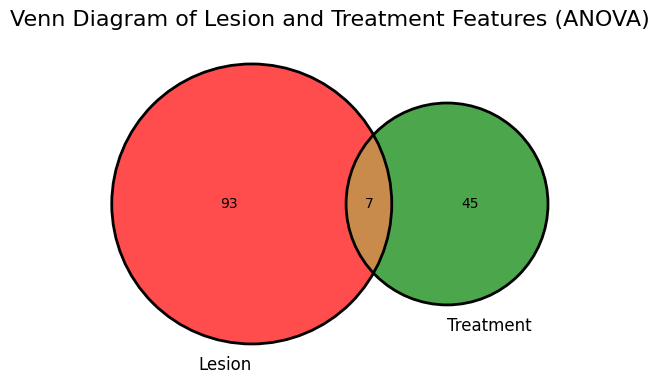

In [15]:
### USING ANOVA PAIRWISE TEST 
lesion_anova_df = treatment_effect_df[treatment_effect_df['Significance Healthy Left B vs Sick Left C'] != 'n.s.']
print(f"Number of significant features that describe the lesion (B pre vs C post): {lesion_anova_df.shape[0]}")

improving_lesion_anova_df = lesion_anova_df[lesion_anova_df['direction'] == 'towards_healthy']
avg_improving_effect_size = improving_lesion_anova_df['change_effect_size'].mean()
print(f"Number of significant lesion features that improve: {improving_lesion_anova_df.shape[0]}. Average effect size: {avg_improving_effect_size:.2f}")

worsening_lesion_anova_df = lesion_anova_df[lesion_anova_df['direction'] == 'away_from_healthy']
avg_worsening_effect_size = worsening_lesion_anova_df['change_effect_size'].mean()
print(f"Number of significant lesion features that worsen: {worsening_lesion_anova_df.shape[0]}. Average effect size: {avg_worsening_effect_size:.2f}")


print('-'*40)
treatment_anova_df = treatment_effect_df[treatment_effect_df['Significance Sick Left C vs Sick Left E'] != 'n.s.']
print(f"Number of significant features that describe the treatment effect (C post vs E post): {treatment_anova_df.shape[0]}")

improving_treatment_anova_df = treatment_anova_df[treatment_anova_df['direction'] == 'towards_healthy']
avg_improving_effect_size = improving_treatment_anova_df['change_effect_size'].mean()
print(f"Number of significant treatment features that improve: {improving_treatment_anova_df.shape[0]}. Average effect size: {avg_improving_effect_size:.2f}")

worsening_treatment_anova_df = treatment_anova_df[treatment_anova_df['direction'] == 'away_from_healthy']
avg_worsening_effect_size = worsening_treatment_anova_df['change_effect_size'].mean()
print(f"Number of significant treatment features that worsen: {worsening_treatment_anova_df.shape[0]}. Average effect size: {avg_worsening_effect_size:.2f}")

print('-'*40)

intersecting_features = set(treatment_anova_df['Feature']).intersection(set(lesion_anova_df['Feature']))

print('-'*40)
print(f"Number of intersecting features between the two comparisons: {len(intersecting_features)}")
print(f"Number of intersecting features that improve: {len(intersecting_features & set(improving_treatment_anova_df['Feature']))}")
print(f"Number of intersecting features that worsen: {len(intersecting_features & set(worsening_treatment_anova_df['Feature']))}")

## Use a venn diagram to display the features
venn2(subsets = (len(treatment_effect_df[treatment_effect_df['Significance Healthy Left B vs Sick Left C'] != 'n.s.']), len(treatment_effect_df[treatment_effect_df['Significance Sick Left C vs Sick Left E'] != 'n.s.']), len(intersecting_features)),
      set_labels = ('Lesion', 
                    'Treatment'),
      set_colors=("red",
                  "green"),alpha=0.7)

# add outline
venn2_circles(subsets=(len(treatment_effect_df[treatment_effect_df['Significance Healthy Left B vs Sick Left C'] != 'n.s.']), len(treatment_effect_df[treatment_effect_df['Significance Sick Left C vs Sick Left E'] != 'n.s.']), len(intersecting_features)))

plt.title("Venn Diagram of Lesion and Treatment Features (ANOVA)", fontsize=16)
# plt.savefig(os.path.join('./', 'venn_diagram_lesion_treatment.svg'), dpi=300, bbox_inches='tight')
plt.show()

## Lesion Feature Distribution pie
labels = ("Improving Lesion Features", "Worsening Lesion Features", "Non-Lesion Features")
sizes = (
    improving_lesion_anova_df.shape[0],
    worsening_lesion_anova_df.shape[0],
    treatment_effect_df[treatment_effect_df['Significance Healthy Left B vs Sick Left C'] == 'n.s.'].shape[0]
)
lesion_fig = go.Figure(
    data=[go.Pie(
        labels=labels, 
        values=sizes, 
        pull=[0, 0, 0.2],
        marker=dict(colors=['green', 'red', 'grey'], line=dict(color='black', width=1))
        )]
)
lesion_fig.update_layout(
    title_text="Lesion Feature Distribution (ANOVA)",
    title_font_size=24,
    legend_title_text="Feature Types",
    legend_title_font_size=18,
    height=400,
    width=600,
)

# lesion_fig.write_image(os.path.join('./', 'lesion_feature_distribution.svg'))
lesion_fig.show()

## Treatment Feature Distribution pie
labels = ("Improving Treatment Features", "Worsening Treatment Features", "Non-Lesion Features")
sizes = (
    improving_treatment_anova_df.shape[0],
    worsening_treatment_anova_df.shape[0],
    treatment_effect_df[treatment_effect_df['Significance Healthy Left B vs Sick Left C'] == 'n.s.'].shape[0]
)
treatment_fig = go.Figure(
    data=[go.Pie(
        labels=labels,
        values=sizes,
        pull=[0, 0, 0.2],
        marker=dict(colors=['green', 'red', 'grey'], line=dict(color='black', width=1))
    )]
)
treatment_fig.update_layout(
    title_text="Treatment Feature Distribution (ANOVA)",
    title_font_size=24,
    legend_title_text="Feature Types",
    legend_title_font_size=18,
    height=400,
    width=600,
)

# treatment_fig.write_image(os.path.join('./', 'treatment_feature_distribution.svg'))
treatment_fig.show()

In [27]:
# 1. Get features significant in both comparisons
sig_b_c = set(treatment_effect_df[treatment_effect_df['Significance Healthy Left B vs Sick Left C'] != 'n.s.']['Feature'])
sig_c_e = set(treatment_effect_df[treatment_effect_df['Significance Sick Left C vs Sick Left E'] != 'n.s.']['Feature'])
print(len(sig_b_c), len(sig_c_e))
sig_both = sig_b_c & sig_c_e
print(len(sig_both))
# 2. Filter for features that are 'towards healthy' in both transitions
improving_both = treatment_effect_df[
    (treatment_effect_df['Feature'].isin(sig_both)) &
    (treatment_effect_df['direction'] == 'towards_healthy')
]
worsening_both = treatment_effect_df[
    (treatment_effect_df['Feature'].isin(sig_both)) &
    (treatment_effect_df['direction'] == 'away_from_healthy')
]

93 45
7


In [ ]:
# ! Get features that are significant for all groups
h_sig_a_b = set(all_healthy_anova_result[all_healthy_anova_result['Significance Healthy Left A vs Healthy Left B'] != 'n.s.']['Feature'])
h_sig_a_c = set(all_healthy_anova_result[all_healthy_anova_result['Significance Healthy Left A vs Healthy Left C'] != 'n.s.']['Feature'])
h_sig_a_d = set(all_healthy_anova_result[all_healthy_anova_result['Significance Healthy Left A vs Healthy Left D'] != 'n.s.']['Feature'])
h_sig_a_e = set(all_healthy_anova_result[all_healthy_anova_result['Significance Healthy Left A vs Healthy Left E'] != 'n.s.']['Feature'])
h_sig_b_c = set(all_healthy_anova_result[all_healthy_anova_result['Significance Healthy Left B vs Healthy Left C'] != 'n.s.']['Feature'])
h_sig_b_d = set(all_healthy_anova_result[all_healthy_anova_result['Significance Healthy Left B vs Healthy Left D'] != 'n.s.']['Feature'])
h_sig_b_e = set(all_healthy_anova_result[all_healthy_anova_result['Significance Healthy Left B vs Healthy Left E'] != 'n.s.']['Feature'])
h_sig_c_d = set(all_healthy_anova_result[all_healthy_anova_result['Significance Healthy Left C vs Healthy Left D'] != 'n.s.']['Feature'])
h_sig_c_e = set(all_healthy_anova_result[all_healthy_anova_result['Significance Healthy Left C vs Healthy Left E'] != 'n.s.']['Feature'])
h_sig_d_e = set(all_healthy_anova_result[all_healthy_anova_result['Significance Healthy Left D vs Healthy Left E'] != 'n.s.']['Feature'])

print(len(h_sig_b_c), len(h_sig_b_e), len(h_sig_c_e))
h_sig_all = h_sig_b_c & h_sig_c_e & h_sig_b_e
print(len(h_sig_all))
## Due to this result, best way to show it is with a UMAP plot

28 36 48
0


In [21]:
lesion_improved_feature_list = improving_lesion_anova_df
lesion_worsened_feature_list = worsening_lesion_anova_df
treatment_improved_feature_list = improving_treatment_anova_df
treatment_worsened_feature_list = worsening_treatment_anova_df
improving_both_feature_list = improving_both
worsening_both_feature_list = worsening_both

to_plot = (lesion_improved_feature_list, lesion_worsened_feature_list, treatment_improved_feature_list, treatment_worsened_feature_list, improving_both_feature_list, worsening_both_feature_list)
# to_plot = (improving_both_feature_list, worsening_both_feature_list)

## look only at cherry picked features
hindlimb_features = {
    'lesion_improved': [],
    'lesion_worsened': [],
    'treatment_improved': [],
    'treatment_worsened': [],
    'improving_both': [],
    'worsening_both': []
}
for i, f_list in enumerate(to_plot):
    cols = f_list['Feature'].str.lower()
    hindlimb_mask = cols.str.lower().str.contains('hindlimb', case=False)
    step_mask = cols.str.lower().str.contains('step', case=False) & ~cols.str.contains('/s', case=False)
    limb_mask = cols.str.lower().str.contains('hindpaw|hindfinger|knee|ankle|hip', case=False)
    meta_mask = cols.str.lower().str.contains('dataset|mouse', case=False)
    final_mask = hindlimb_mask | step_mask | meta_mask | limb_mask

    f_list = f_list.loc[final_mask, :]
    # hindlimb_features[list(hindlimb_features.keys())[i]].extend(f_list['Feature'].tolist())

    fig = plot_features_list_across_groups(f_list['Feature'].tolist(), feature_subsets, limb='hindlimb',
                                     groups=['healthy_left_B_', 'sick_left_C_', 'sick_left_E_'])
    fig.write_image(os.path.join('./', f'features_{list(hindlimb_features.keys())[i]}.svg'))
    fig.show()


Number of significant features that describe the lesion (ALL pre vs B & C post): 256
Number of significant lesion features that improve: 144. Average effect size: 0.36
Number of significant lesion features that worsen: 112. Average effect size: -0.35
----------------------------------------
Number of significant features that describe the treatment effect (B & C post vs E post): 158
Number of significant treatment features that improve: 42. Average effect size: 0.35
Number of significant treatment features that worsen: 116. Average effect size: -0.52
----------------------------------------
----------------------------------------
Number of intersecting features between the two comparisons: 30
Number of intersecting features that improve: 13
Number of intersecting features that worsen: 17


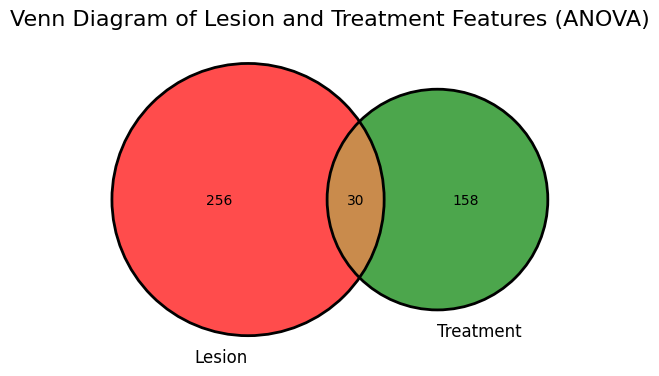

In [18]:
### USING ANOVA PAIRWISE TEST 
lesion_anova_df = treatment_effect_df_expanded[treatment_effect_df_expanded['Significance All Healthy vs B Sick & C Sick'] != 'n.s.']
print(f"Number of significant features that describe the lesion (ALL pre vs B & C post): {lesion_anova_df.shape[0]}")

improving_lesion_anova_df = lesion_anova_df[lesion_anova_df['direction'] == 'towards_healthy']
avg_improving_effect_size = improving_lesion_anova_df['change_effect_size'].mean()
print(f"Number of significant lesion features that improve: {improving_lesion_anova_df.shape[0]}. Average effect size: {avg_improving_effect_size:.2f}")

worsening_lesion_anova_df = lesion_anova_df[lesion_anova_df['direction'] == 'away_from_healthy']
avg_worsening_effect_size = worsening_lesion_anova_df['change_effect_size'].mean()
print(f"Number of significant lesion features that worsen: {worsening_lesion_anova_df.shape[0]}. Average effect size: {avg_worsening_effect_size:.2f}")


print('-'*40)
treatment_anova_df = treatment_effect_df_expanded[treatment_effect_df_expanded['Significance B Sick & C Sick vs E Treatment'] != 'n.s.']
print(f"Number of significant features that describe the treatment effect (B & C post vs E post): {treatment_anova_df.shape[0]}")

improving_treatment_anova_df = treatment_anova_df[treatment_anova_df['direction'] == 'towards_healthy']
avg_improving_effect_size = improving_treatment_anova_df['change_effect_size'].mean()
print(f"Number of significant treatment features that improve: {improving_treatment_anova_df.shape[0]}. Average effect size: {avg_improving_effect_size:.2f}")

worsening_treatment_anova_df = treatment_anova_df[treatment_anova_df['direction'] == 'away_from_healthy']
avg_worsening_effect_size = worsening_treatment_anova_df['change_effect_size'].mean()
print(f"Number of significant treatment features that worsen: {worsening_treatment_anova_df.shape[0]}. Average effect size: {avg_worsening_effect_size:.2f}")

print('-'*40)

intersecting_features = set(treatment_anova_df['Feature']).intersection(set(lesion_anova_df['Feature']))

print('-'*40)
print(f"Number of intersecting features between the two comparisons: {len(intersecting_features)}")
print(f"Number of intersecting features that improve: {len(intersecting_features & set(improving_treatment_anova_df['Feature']))}")
print(f"Number of intersecting features that worsen: {len(intersecting_features & set(worsening_treatment_anova_df['Feature']))}")

## Use a venn diagram to display the features
venn2(subsets = (len(treatment_effect_df_expanded[treatment_effect_df_expanded['Significance All Healthy vs B Sick & C Sick'] != 'n.s.']), len(treatment_effect_df_expanded[treatment_effect_df_expanded['Significance B Sick & C Sick vs E Treatment'] != 'n.s.']), len(intersecting_features)),
      set_labels = ('Lesion', 
                    'Treatment'),
      set_colors=("red",
                  "green"),alpha=0.7)

# add outline
venn2_circles(subsets=(len(treatment_effect_df_expanded[treatment_effect_df_expanded['Significance All Healthy vs B Sick & C Sick'] != 'n.s.']), len(treatment_effect_df_expanded[treatment_effect_df_expanded['Significance B Sick & C Sick vs E Treatment'] != 'n.s.']), len(intersecting_features)))

plt.title("Venn Diagram of Lesion and Treatment Features (ANOVA)", fontsize=16)
# plt.savefig(os.path.join('./', 'venn_diagram_lesion_treatment.svg'), dpi=300, bbox_inches='tight')
plt.show()

## Lesion Feature Distribution pie
labels = ("Improving Lesion Features", "Worsening Lesion Features", "Non-Lesion Features")
sizes = (
    improving_lesion_anova_df.shape[0],
    worsening_lesion_anova_df.shape[0],
    treatment_effect_df_expanded[treatment_effect_df_expanded['Significance All Healthy vs B Sick & C Sick'] == 'n.s.'].shape[0]
)
lesion_fig = go.Figure(
    data=[go.Pie(
        labels=labels, 
        values=sizes, 
        pull=[0, 0, 0.2],
        marker=dict(colors=['green', 'red', 'grey'], line=dict(color='black', width=1))
        )]
)
lesion_fig.update_layout(
    title_text="Lesion Feature Distribution (ANOVA)",
    title_font_size=24,
    legend_title_text="Feature Types",
    legend_title_font_size=18,
    height=400,
    width=600,
)

# lesion_fig.write_image(os.path.join('./', 'lesion_feature_distribution.svg'))
lesion_fig.show()

## Treatment Feature Distribution pie
labels = ("Improving Treatment Features", "Worsening Treatment Features", "Non-Lesion Features")
sizes = (
    improving_treatment_anova_df.shape[0],
    worsening_treatment_anova_df.shape[0],
    treatment_effect_df_expanded[treatment_effect_df_expanded['Significance All Healthy vs B Sick & C Sick'] == 'n.s.'].shape[0]
)
treatment_fig = go.Figure(
    data=[go.Pie(
        labels=labels,
        values=sizes,
        pull=[0, 0, 0.2],
        marker=dict(colors=['green', 'red', 'grey'], line=dict(color='black', width=1))
    )]
)
treatment_fig.update_layout(
    title_text="Treatment Feature Distribution (ANOVA)",
    title_font_size=24,
    legend_title_text="Feature Types",
    legend_title_font_size=18,
    height=400,
    width=600,
)

# treatment_fig.write_image(os.path.join('./', 'treatment_feature_distribution.svg'))
treatment_fig.show()